<h1 style="text-align: center;">Assignment 2</h1>



In [1]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
import networkx as nx
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
from tqdm.notebook import tqdm
import json
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from matplotlib.lines import Line2D
import ast

import warnings
warnings.filterwarnings("ignore")
###############################################################

#################### Functions ################################

def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

def check_if_present_in_links(dc_df, marvel_df, link):
    target = dc_df.loc[dc_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    target = marvel_df.loc[marvel_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    return None

def check_if_present_in_names(dc_df, marvel_df, name):
    target = dc_df.loc[dc_df['CharacterName'] == name]
    if not target.empty:
        return name
    target = marvel_df.loc[marvel_df['CharacterName'] == name]
    if not target.empty:
        return name
    
    return None
    
def get_name_from_link(df, link):
    target = df.loc[df['WikiLink'] == link]
    return target['CharacterName']
    
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

def get_filename_from_charactername(character_name):
    return character_name.replace(" ", "_*_").replace("/","-*-")

###############################################################

################### Global Definitions ########################
dc_unv = "DC"
marvel_unv = "Marvel"
universes = [dc_unv, marvel_unv]
data_folder = "../Data/"
###############################################################

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Data

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

In [2]:
# Load Graph
DC_Marvel_Graph = nx.read_gpickle("../Data/graph.gpickle")

# Load Wikipages as a dictionary with key the CharacterName and value the text of the wikipage
with open('../Data/wikipages.txt') as f:
    data = f.read()
    
wikipages_text = ast.literal_eval(data)
  

# Basic Stats

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links. 
* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

We also want the degree distributions and a plot of the network

* Create in- and out-going degree distributions as described in Lecture 5.
* Estimate the slope of the incoming degree distribtion as described in Lecture 5.
* Plot the network using the Force Atlas algorithm as described in Lecture 5.

(Friendly hint: Remember figure captions.)

### Paragraph

To write here.

In [3]:
def print_statistics(my_graph, name):
    
    in_degrees = np.array([val for node,val in list(my_graph.in_degree())])
    out_degrees = np.array([val for node,val in list(my_graph.out_degree())])
    
    print(f"\nDegree Statistics of the {name}.")
    print("\tIn-Degree Statistics:")
    print(f"\t\tAverage = {np.mean(in_degrees):.2f}, Median = {np.median(in_degrees):.2f},Mode={stats.mode(in_degrees)},\
                            \n\t\tMinimum = {np.min(in_degrees):.2f}, Maximum = {np.max(in_degrees):.2f}.")
    print("\n\tOut-Degree Statistics:")
    print(f"\t\tAverage = {np.mean(out_degrees):.2f}, Median = {np.median(out_degrees):.2f},Mode={stats.mode(out_degrees)},\
                            \n\t\tMinimum = {np.min(out_degrees):.2f}, Maximum = {np.max(out_degrees):.2f}.")

    

print(f"Number of nodes: {DC_Marvel_Graph.number_of_nodes()}")
print(f"Number of edges: {DC_Marvel_Graph.number_of_edges()}")

in_degrees = sorted(list(DC_Marvel_Graph.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(DC_Marvel_Graph.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]

from scipy import stats
in_degrees_np = np.array(in_only_degrees)
out_degrees_np = np.array(out_only_degrees)

DC_nodes = (
    node
    for node, data
    in DC_Marvel_Graph.nodes(data=True)
    if data.get("universe") == "DC"
)
DC_subgraph = DC_Marvel_Graph.subgraph(DC_nodes)

Marvel_nodes = (
    node
    for node, data
    in DC_Marvel_Graph.nodes(data=True)
    if data.get("universe") == "Marvel"
)
Marvel_subgraph = DC_Marvel_Graph.subgraph(Marvel_nodes)


print_statistics(DC_Marvel_Graph, "DC - Marvel Network")

print_statistics(DC_subgraph, "DC Network")

print_statistics(Marvel_subgraph, "Marvel Network")


Number of nodes: 2276
Number of edges: 30869

Degree Statistics of the DC - Marvel Network.
	In-Degree Statistics:
		Average = 13.56, Median = 5.00,Mode=ModeResult(mode=array([0]), count=array([396])),                            
		Minimum = 0.00, Maximum = 467.00.

	Out-Degree Statistics:
		Average = 13.56, Median = 9.00,Mode=ModeResult(mode=array([0]), count=array([593])),                            
		Minimum = 0.00, Maximum = 128.00.

Degree Statistics of the DC Network.
	In-Degree Statistics:
		Average = 10.95, Median = 4.00,Mode=ModeResult(mode=array([0]), count=array([104])),                            
		Minimum = 0.00, Maximum = 221.00.

	Out-Degree Statistics:
		Average = 10.95, Median = 8.00,Mode=ModeResult(mode=array([0]), count=array([58])),                            
		Minimum = 0.00, Maximum = 61.00.

Degree Statistics of the Marvel Network.
	In-Degree Statistics:
		Average = 13.45, Median = 5.00,Mode=ModeResult(mode=array([0]), count=array([305])),                     

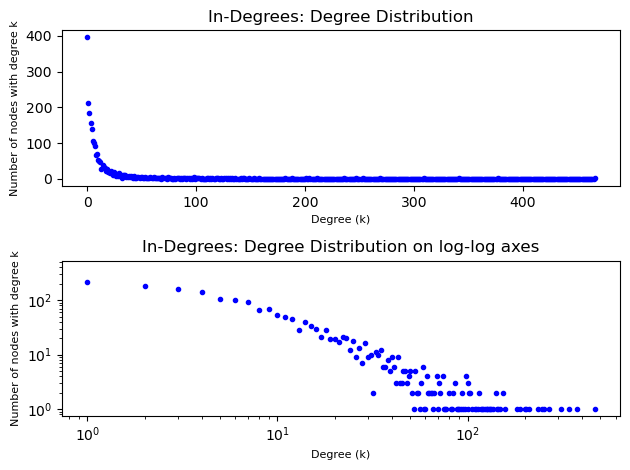

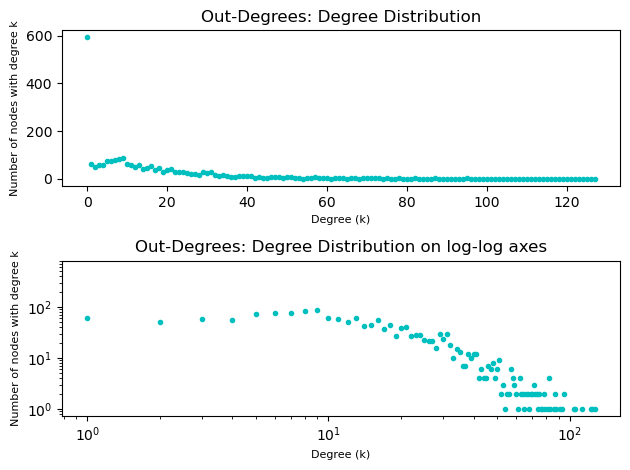

In [4]:
def plot_degree_distribution(degrees, title, color):
    counts, limits = np.histogram(degrees, degrees[0])

    x = limits[:len(counts)]
    y = counts

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x, y, color)
    ax1.set_title(title)
    ax1.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax1.set_xlabel('Degree (k)',fontsize=8)

    ax2 =plt.subplot(2, 1, 2)
    ax2.loglog(x, y, color)
    ax2.set_title(title + ' on log-log axes')
    ax2.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax2.set_xlabel('Degree (k)',fontsize=8 )

    plt.tight_layout()
    plt.show()
    
    

plot_degree_distribution(in_only_degrees, "In-Degrees: Degree Distribution", 'b.')

plot_degree_distribution(out_only_degrees, "Out-Degrees: Degree Distribution", 'c.')

In [5]:
import powerlaw 

in_degrees = np.array([val for node,val in list(DC_Marvel_Graph.in_degree())])
out_degrees = np.array([val for node,val in list(DC_Marvel_Graph.out_degree())])
    
fit = powerlaw.Fit(in_degrees)

print(f"In Degrees slope = {fit.alpha:.2f}")

fit = powerlaw.Fit(out_degrees)

print(f"Out degrees slope = {fit.alpha:.2f}")

Calculating best minimal value for power law fit
In Degrees slope = 2.54
Calculating best minimal value for power law fit
Out degrees slope = 3.48


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [6]:
maxcc = max(nx.weakly_connected_components(DC_Marvel_Graph), key=len)

GCC = DC_Marvel_Graph.subgraph(maxcc)

print("Number of Nodes of Largest Connected Component = {}".format(GCC.number_of_nodes()))
print("Number of Edges of Largest Connected Component = {}".format(GCC.number_of_edges()))

Number of Nodes of Largest Connected Component = 2090
Number of Edges of Largest Connected Component = 30866


Number of edges after converting to undirected = 26800


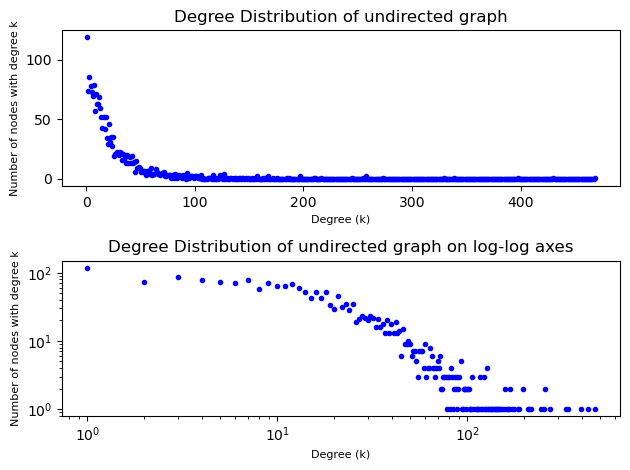

In [7]:
GCC_undirected = GCC.to_undirected()

print("Number of edges after converting to undirected = {}".format(GCC_undirected.number_of_edges()))


#Degree Distribution

degrees = sorted(list(GCC_undirected.degree()),key=lambda d: d[1], reverse=True)

degrees_only = [val for node,val in degrees]


plot_degree_distribution(degrees_only, "Degree Distribution of undirected graph", 'b.')

100%|██████████| 2000/2000 [01:07<00:00, 29.81it/s]


BarnesHut Approximation  took  16.70  seconds
Repulsion forces  took  47.48  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.68  seconds
AdjustSpeedAndApplyForces step  took  0.92  seconds


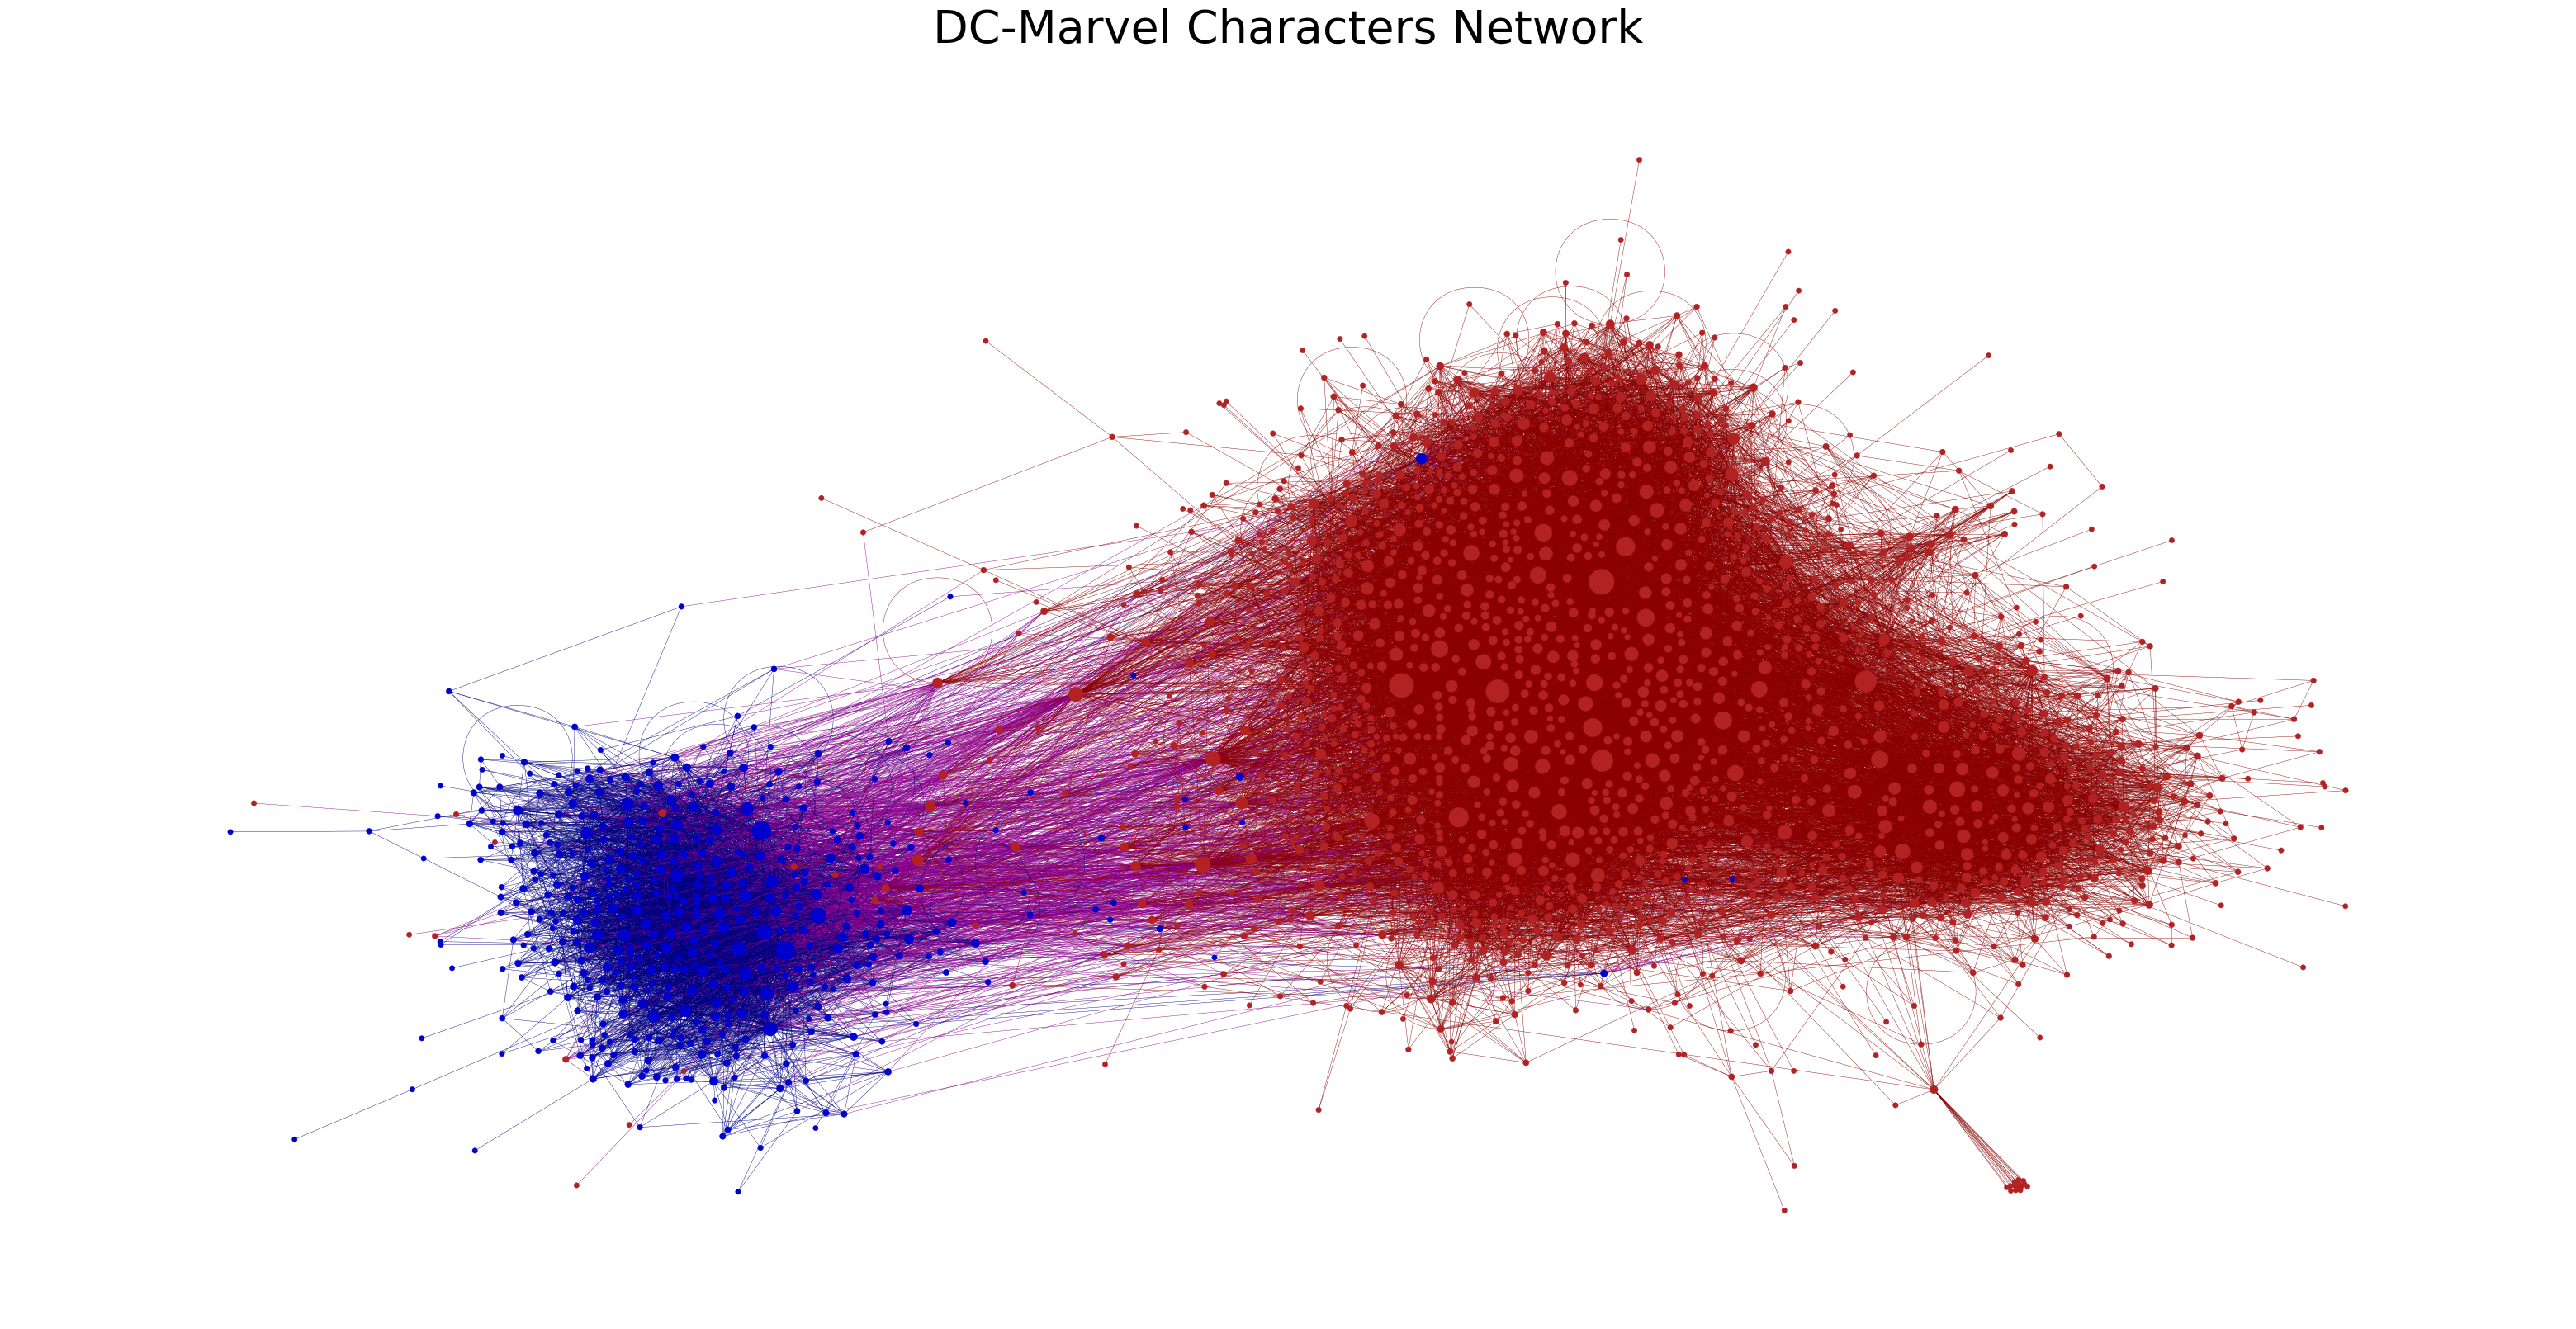

In [8]:
from fa2 import ForceAtlas2

node_sizes = [val+20 for node, val in GCC_undirected.degree()]
node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in GCC_undirected.nodes(data=True)]
edge_colors = ['#000080' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "DC"\
               else '#8B0000' if GCC_undirected.nodes[node1]['universe'] == GCC_undirected.nodes[node2]['universe'] == "Marvel" \
               else '#8B008B' for node1,node2 in GCC_undirected.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,20))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('DC-Marvel Characters Network',fontsize = 40) 

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)
nx.draw(GCC_undirected,positions, **args, ax=ax)

plt.show()

# Communities

Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.

In [20]:
def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1


labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average

labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

#create a dictionary with the tokenized text as value and key characterName
tokens = dict()

#remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

for item in wikipages_text.items():    
    tokens[item[0]] = tokenizer.tokenize(item[1].lower())
    
    
#calculate sentiment per character
sentiment_per_character = dict(zip(tokens.keys(), map(calculate_sentiment,tokens.values())))


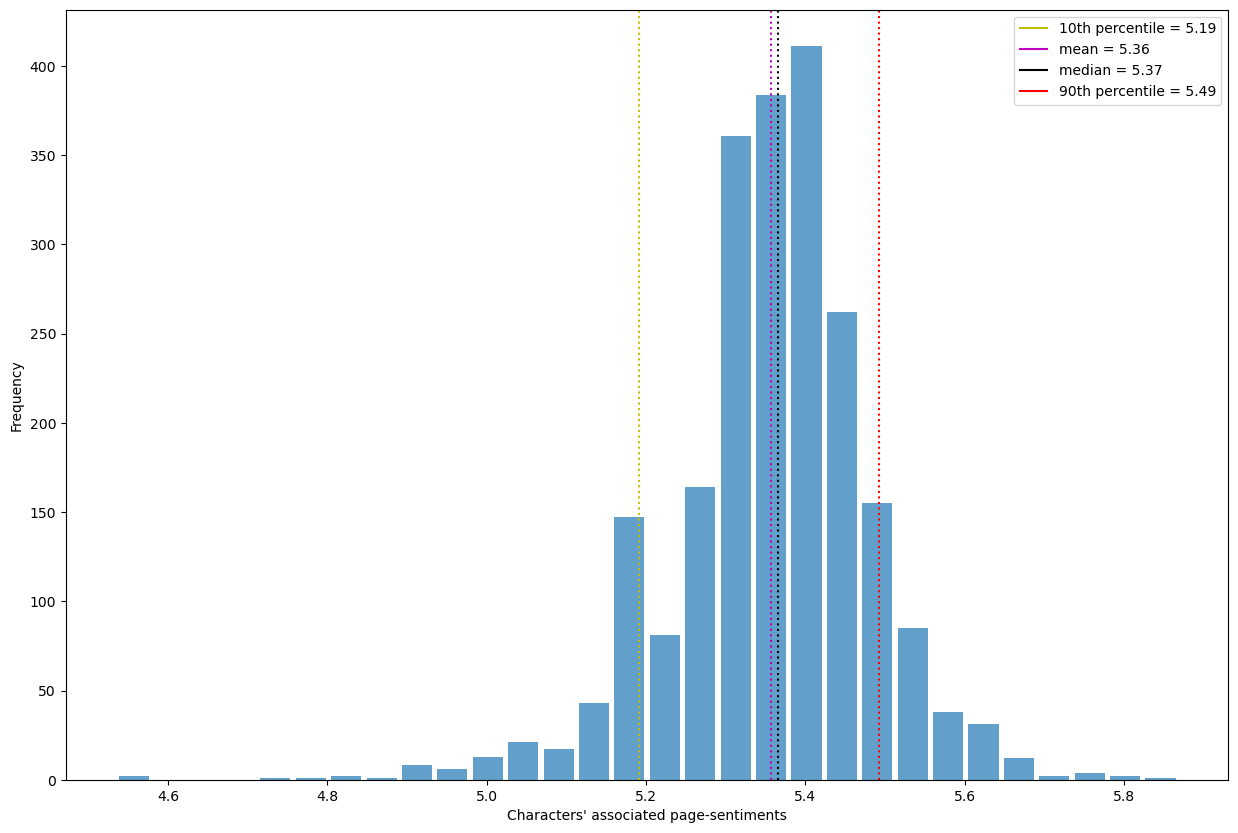

In [21]:
def plot_sentiment(dictionary):
    fig, ax = plt.subplots(figsize = (15,10))
    
    num_of_bins = 30
    counts , edges = np.histogram(list(dictionary.values()),bins=num_of_bins)
    
    max_count = np.max(counts)
    spc = list(dictionary.values())
    plt.hist(spc, bins = num_of_bins, alpha=0.7, rwidth=0.85)

    # Calculate percentiles
    percentile_10, median, mean, percentile_90 = np.percentile(spc,10),np.percentile(spc,50),np.mean(spc), np.percentile(spc,90)

    # [quantile, opacity, length]
    quants = [[percentile_10, "y"], [mean, "m"], [median, "k"],  [percentile_90, "r"]]

    # Plot the lines with a loop
    for i in quants:
        ax.axvline(i[0], color=i[1], linestyle = ":")

#     ax.text(percentile_10-.05, 0.25* max_count, f"10th = {percentile_10:.2f}", size = 10, alpha = 0.8)
#     ax.text(median-.03, 0.75* max_count, "median", size = 11, alpha = 0.85)
#     ax.text(mean, 0.5* max_count, "mean", size = 12, alpha = 1)
#     ax.text(percentile_90, 0.9* max_count, "90th", size = 11, alpha = 0.85)

    legends = [Line2D([0], [0], marker=None, color=quants[0][1], label= f"10th percentile = {quants[0][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[1][1], label= f"mean = {quants[1][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[2][1], label= f"median = {quants[2][0]:.2f}"),
               Line2D([0], [0], marker=None, color=quants[3][1], label= f"90th percentile = {quants[3][0]:.2f}")]

    ax.set_xlabel("Characters' associated page-sentiments")
    ax.set_ylabel("Frequency")
    
    
    plt.legend(handles = legends, loc=1, fontsize = 10)
    plt.show()
    return mean

average_of_all = plot_sentiment(sentiment_per_character)
               

In [22]:
sorted_sentiment_per_character = dict(sorted(sentiment_per_character.items(), key=lambda item: item[1], reverse=True))

print("5 happiest:")
i = 0
for char in sorted_sentiment_per_character:
    if i >= 5:
        break
    print(f"{char}: {sorted_sentiment_per_character[char]}")
    i+=1

sorted_sentiment_per_character = dict(sorted(sentiment_per_character.items(), key=lambda item: item[1]))
print("5 saddest:")
i = 0
for char in sorted_sentiment_per_character:
    if i >= 5:
        break
    print(f"{char}: {sorted_sentiment_per_character[char]}")
    i+=1

5 happiest:
Lifeform: 5.868
Free Spirit: 5.7870833333333325
Super Rabbit: 5.782000000000001
Von Bach: 5.766666666666667
Fancy Dan: 5.766666666666667
5 saddest:
Voice: 4.535
Lodestone: 4.535
Stinger: 4.756666666666667
Shiva: 4.796
Albert Cleary: 4.8325000000000005


In [27]:
good_bad = pd.read_table("../Data/good_bad.txt", delimiter=",")

#create a dictionary with key the CharacterName and value = 10 if good, 1 if bad, 0 if neutral
char_mapping = {"good":10, "bad":1, "neutral":0}
good_bad_dictionary = dict(zip(good_bad["CharacterName"], good_bad["good"]*10+good_bad["bad"]))

In [28]:
sentiment_per_good_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["good"]}

sentiment_per_bad_character = {characterName: sentiment for characterName, sentiment 
                                in sentiment_per_character.items() 
                                if good_bad_dictionary[characterName] == char_mapping["bad"]}

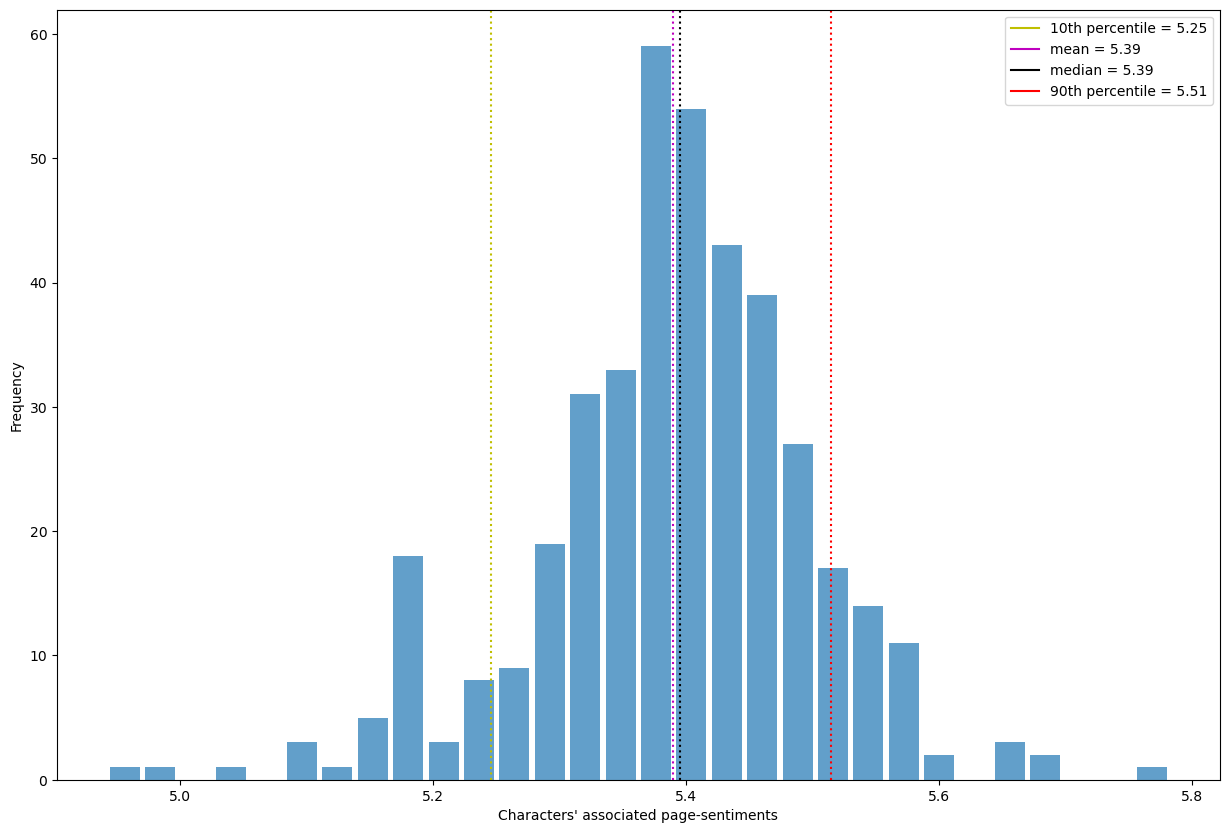

In [29]:
average_of_good = plot_sentiment(sentiment_per_good_character)

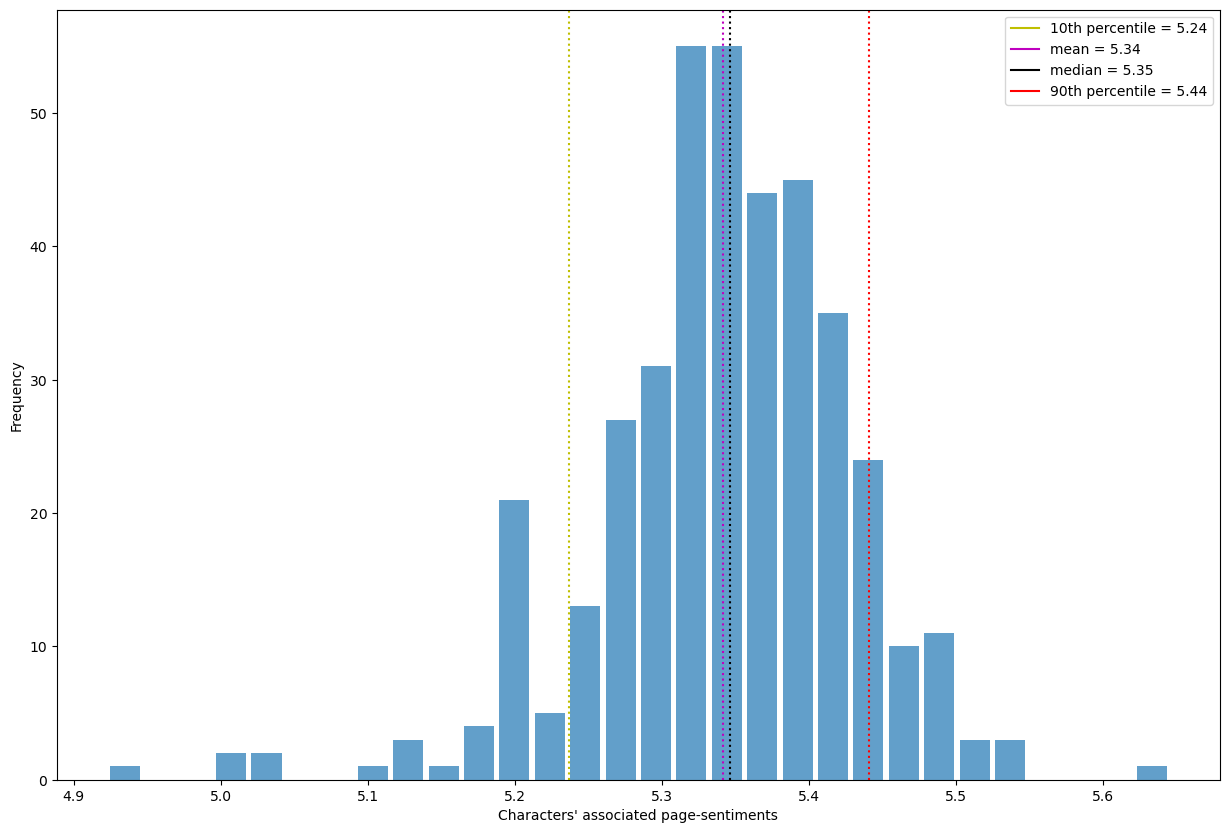

In [30]:
average_of_bad = plot_sentiment(sentiment_per_bad_character)

In [31]:
print(f"Average sentiment of all characters: {average_of_all:.2f}")
print(f"Average sentiment of good characters: {average_of_good:.2f}")
print(f"Average sentiment of bad characters: {average_of_bad:.2f}")

Average sentiment of all characters: 5.36
Average sentiment of good characters: 5.39
Average sentiment of bad characters: 5.34


In [32]:
mean_sentiment_of_random_characters = []
good_characters_number = len(sentiment_per_good_character)
characters = list(sentiment_per_character.keys())
for i in range(2000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:good_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/good_characters_number
    mean_sentiment_of_random_characters.append(average)
    
p_value = len([x for x in mean_sentiment_of_random_characters if x >= average_of_good])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value:.2f}%")

p-value = 0.0%


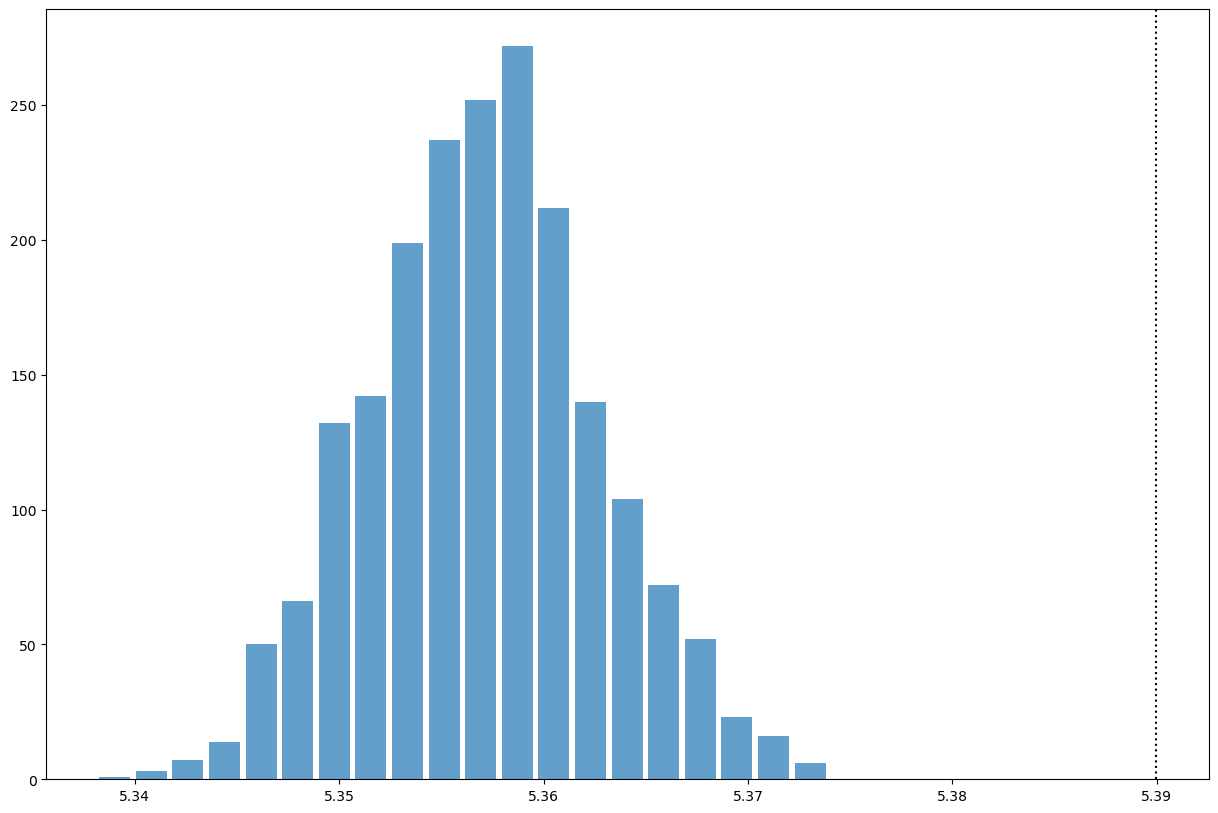

In [33]:
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_good, color="k", linestyle = ":")
plt.show()

In [34]:
mean_sentiment_of_random_characters = []
bad_characters_number = len(sentiment_per_bad_character)
characters = list(sentiment_per_character.keys())
for i in range(10000):
    # get we need same size as the good characters so we ll get the first G characters
    # where G is the number of good characters
    random_characters = np.random.permutation(characters)[:bad_characters_number]
    average = sum(sentiment_per_character[char] for char in random_characters)/bad_characters_number
    mean_sentiment_of_random_characters.append(average)
    
p_value = len([x for x in mean_sentiment_of_random_characters if x <= average_of_bad])/len(mean_sentiment_of_random_characters)

print(f"p-value = {p_value*100:.2f}%")

p-value = 0.2800%


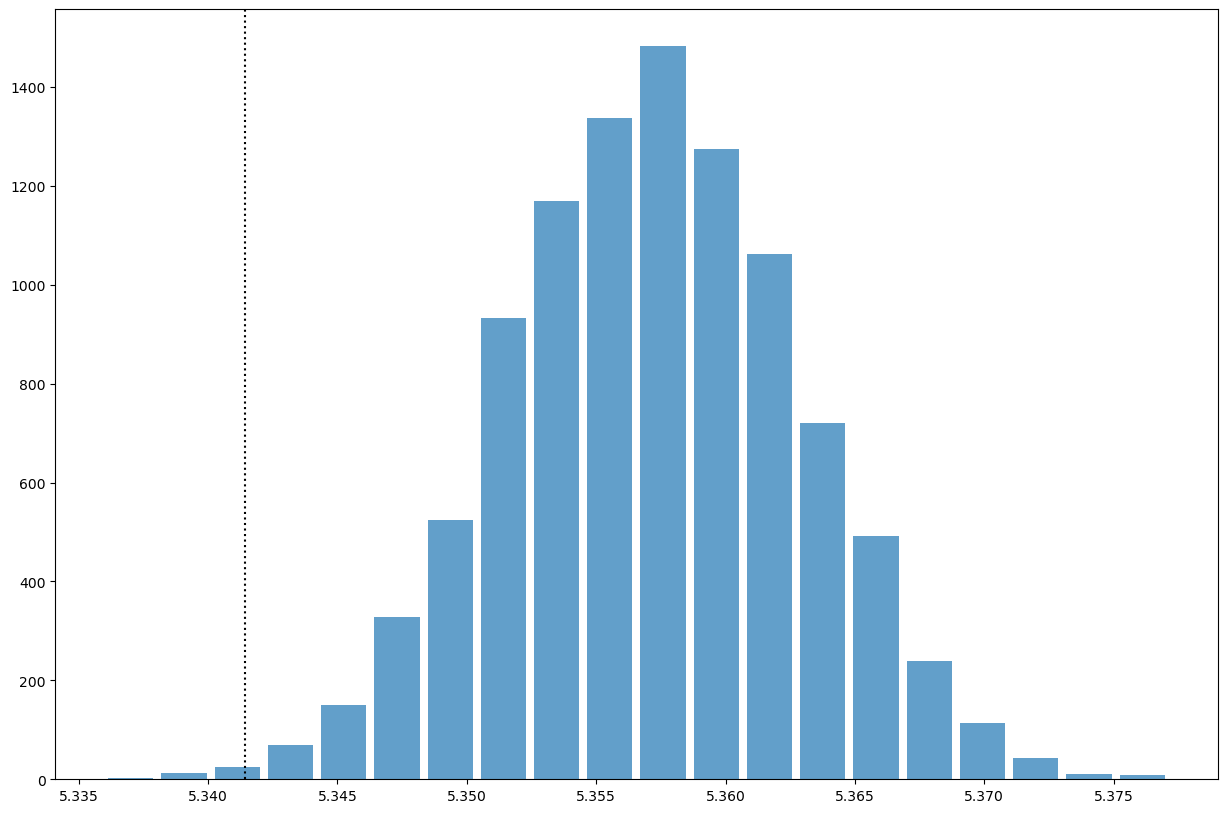

In [35]:
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(mean_sentiment_of_random_characters, bins = 20, alpha=0.7, rwidth=0.85)
ax.axvline(average_of_bad, color="k", linestyle = ":")
plt.show()